# Deep Q-Learning for Lunar Landing

## Part 0 - Installing the required packages and importing the libraries

### Installing Gymnasium

In [1]:
!pip install gymnasium
!pip install gymnasium==1.0.0
!pip install swig
!pip install "gymnasium[box2d]"
!pip install imageio
!pip install ipython
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu128
!pip install "imageio[ffmpeg]"
!pip install "imageio[ffmpeg]"

Looking in indexes: https://download.pytorch.org/whl/cu128


### Checking for availibility of CUDA Cores

In [2]:
import torch
if torch.cuda.is_available():
    cuda_bit = 1
else:
    cuda_bit = 0

print(torch.cuda.is_available())

True


### Importing the libraries

In [3]:
import os #for os
import random #for random numbers
import numpy as np #for arrays
import torch # to train agent w pytorch
import torch.nn as nn #neural network module
import torch.optim as optim # optimal module
import torch.nn.functional as F #functions pre made for training
import torch.autograd as autograd # for stochastic gradient descent
from torch.autograd import Variable #training
from collections import deque, namedtuple #training

## Part 1 - Building the AI

### Creating the architecture of the Neural Network

In [4]:
class NeuNet(nn.Module): #inherits from nn.module

  def __init__(self, state_size, action_size, seed=42):
    super(NeuNet, self).__init__()
    self.seed = torch.manual_seed(seed)
    self.fc1 = nn.Linear(state_size, 128) #Input Layer
    self.fc2 = nn.Linear(128, 128) #Hidden Layer
    self.fc3 = nn.Linear(128, action_size) #Output Layer

  def forward(self, state):
    x = self.fc1(state)
    x = F.relu(x) #rectifier activation function from torch.nn.functional
    #Gone from first fully conected layer to the second
    x = self.fc2(x)
    x = F.relu(x)
    return self.fc3(x) #output layer

## Part 2 - Training the AI

### Setting up the environment

In [5]:
import gymnasium as gym
env = gym.make("LunarLander-v3")
state_shape = env.observation_space.shape #Vector
state_size = env.observation_space.shape[0] #current state of env
number_actions = env.action_space.n #Number of actions
print('State shape: ', state_shape)
print('State size: ', state_size)
print('Number of actions: ', number_actions)

State shape:  (8,)
State size:  8
Number of actions:  4


### Implementing Experience Replay

In [6]:
class ReplayMemory(object):

  def __init__(self, capacity):
    self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #if exterior device(gpu) is present. uses that hardware to process
    self.capacity = capacity #total size of memory size
    self.memory = [ ]

  def push(self, event): #appends event and removes oldest event if memory is full
    self.memory.append(event)
    if len(self.memory) > self.capacity:
      del self.memory[0]

  def sample(self, batch_size):
    exp = random.sample(self.memory, k = batch_size)
    state = torch.from_numpy(np.vstack([e[0] for e in exp if e is not None])).float().to(self.device) #states converted to tensors and float values and send to gpu or cpu
    action = torch.from_numpy(np.vstack([e[1] for e in exp if e is not None])).long().to(self.device) #same as states but long integers
    rewards = torch.from_numpy(np.vstack([e[2] for e in exp if e is not None])).float().to(self.device)
    next_state = torch.from_numpy(np.vstack([e[3] for e in exp if e is not None])).float().to(self.device)
    dones = torch.from_numpy(np.vstack([e[4] for e in exp if e is not None]).astype(np.uint8)).float().to(self.device)
    return state, next_state, action, rewards, dones

### Implementing the DQN class

In [ ]:
class Agent():
    def __init__(self, state_size, action_size, learning_rate, replay_buffer_size = 100000, gamma, tau, minibatch_size):
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.state_size = state_size
        self.action_size = action_size
        self.local_qnetwork = NeuNet(state_size, action_size).to(self.device)
        self.target_qnetwork = NeuNet(state_size, action_size).to(self.device)
        self.optimizer = optim.Adam(self.local_qnetwork.parameters(), lr=learning_rate)
        self.memory = ReplayMemory(replay_buffer_size)
        self.gamma = gamma
        self.tau = tau
        self.minibatch_size = minibatch_size
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):
        self.memory.push((state, action, reward, next_state, done))
        self.t_step = (self.t_step + 1) % 4
        if self.t_step == 0:
            if len(self.memory.memory) > self.minibatch_size:
                exp_local = self.memory.sample(self.minibatch_size)
                self.learn(exp_local)

    def act(self, state, epsilon=0.):
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        self.local_qnetwork.eval()
        with torch.no_grad():
            action_values = self.local_qnetwork(state)
        self.local_qnetwork.train()
        if random.random() > epsilon:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, exp):
        states, next_states, actions, rewards, dones = exp
        next_q_targets = self.target_qnetwork(next_states).detach().max(1)[0].unsqueeze(1)
        q_targets = rewards + (self.gamma * next_q_targets * (1 - dones))
        q_expected = self.local_qnetwork(states).gather(1, actions)
        loss = F.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.soft_update(self.local_qnetwork, self.target_qnetwork)

    def soft_update(self, local_model, target_model):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(self.tau * local_param.data + (1.0 - self.tau) * target_param.data)


### Initializing the DQN agent

In [ ]:
agent = Agent(state_size, number_actions)

NameError: name 'state_size' is not defined

### Training the DQN agent

In [21]:
import time

def run_training(agent, num_episodes=500, max_timesteps=1000):
    epsilon = 1.0
    epsilon_end = 0.01
    epsilon_decay = 0.995
    scores = deque(maxlen=100)
    start_time = time.time()

    for episode in range(1, num_episodes + 1):
        state, _ = env.reset()
        score = 0
        for t in range(max_timesteps):
            action = agent.act(state, epsilon)
            next_state, reward, done, _, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        scores.append(score)
        epsilon = max(epsilon_end, epsilon_decay * epsilon)

        if episode % 100 == 0:
            avg_score = np.mean(scores)
            elapsed = time.time() - start_time
            print(f"Episode {episode} | Avg Last 100: {avg_score:.2f} | Time Elapsed: {elapsed:.2f}s")

    elapsed = time.time() - start_time
    final_avg = np.mean(list(scores)[-50:])
    return elapsed, final_avg


In [22]:
import itertools
import csv

learning_rates = [1e-4, 5e-4, 1e-3]
gammas = [0.95, 0.99, 0.999]
taus = [1e-3, 1e-2, 1e-1]

minibatch_size = 256
replay_buffer_size = 100000

results = []

with open("hyperparam_results.csv", mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["LR", "Gamma", "Tau", "Elapsed_Time", "Final_Avg_Score"])
    
    for lr, g, tau_val in itertools.product(learning_rates, gammas, taus):
        print(f"Testing: LR={lr}, Gamma={g}, Tau={tau_val}")
        agent = Agent(state_size, number_actions, lr, replay_buffer_size, g, tau_val, minibatch_size)
        elapsed, avg_score = run_training(agent)
        writer.writerow([lr, g, tau_val, elapsed, avg_score])
        results.append((lr, g, tau_val, elapsed, avg_score))

# Report best result
if results:
    best = max(results, key=lambda x: x[-1])
    print(f"\nBest combination:")
    print(f"LR={best[0]}, Gamma={best[1]}, Tau={best[2]}")
    print(f"Final Avg Score={best[4]:.2f}, Time={best[3]:.2f}s")
else:
    print("No valid results recorded.")


Testing: LR=0.0001, Gamma=0.95, Tau=0.001
Episode 100 | Avg Last 100: -157.86 | Time Elapsed: 19.18s
Episode 200 | Avg Last 100: -139.58 | Time Elapsed: 67.17s
Episode 300 | Avg Last 100: -96.09 | Time Elapsed: 191.05s
Episode 400 | Avg Last 100: -46.54 | Time Elapsed: 365.02s
Episode 500 | Avg Last 100: -79.49 | Time Elapsed: 557.23s
Testing: LR=0.0001, Gamma=0.95, Tau=0.01
Episode 100 | Avg Last 100: -191.06 | Time Elapsed: 20.29s
Episode 200 | Avg Last 100: -104.53 | Time Elapsed: 65.98s
Episode 300 | Avg Last 100: 18.05 | Time Elapsed: 172.85s
Episode 400 | Avg Last 100: 57.93 | Time Elapsed: 272.45s
Episode 500 | Avg Last 100: -34.94 | Time Elapsed: 411.88s
Testing: LR=0.0001, Gamma=0.95, Tau=0.1
Episode 100 | Avg Last 100: -160.29 | Time Elapsed: 17.36s
Episode 200 | Avg Last 100: -64.37 | Time Elapsed: 67.95s
Episode 300 | Avg Last 100: 24.16 | Time Elapsed: 199.43s
Episode 400 | Avg Last 100: -7.57 | Time Elapsed: 339.26s
Episode 500 | Avg Last 100: -33.44 | Time Elapsed: 487.1

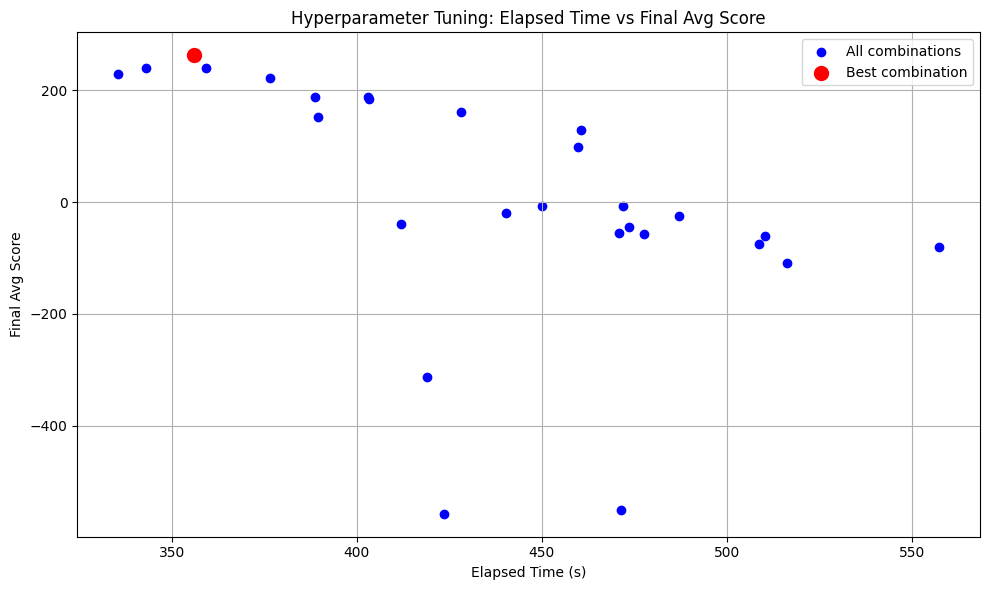


Best combination:
LR                   0.000500
Gamma                0.990000
Tau                  0.010000
Elapsed_Time       355.981510
Final_Avg_Score    262.892683
Name: 13, dtype: float64


In [23]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv("hyperparam_results.csv")
best_idx = df['Final_Avg_Score'].idxmax()
best_row = df.iloc[best_idx]

plt.figure(figsize=(10, 6))
plt.scatter(df["Elapsed_Time"], df["Final_Avg_Score"], color="blue", label="All combinations")
plt.scatter(best_row["Elapsed_Time"], best_row["Final_Avg_Score"], color="red", label="Best combination", s=100)

plt.xlabel("Elapsed Time (s)")
plt.ylabel("Final Avg Score")
plt.title("Hyperparameter Tuning: Elapsed Time vs Final Avg Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\nBest combination:")
print(best_row)
